# Titanic Data Analysis with Captum

Captum의 사용법을 익히기 위해 실습입니다.

아래 튜토리얼을 참조하였습니다.
https://captum.ai/tutorials/

이번 실습에서는 타이타닉 생존 여부 예측 모델에 Captum의 Interpretability Library를 사용하여 모델이 어떤 feature를 중요하게 보고 있는지 파악하고자 합니다.

순서는 다음과 같습니다.
1) 데이터를 불러오고 전처리합니다.

2) pytorch를 사용하여 DNN 기반 모델을 만들고 이를 학습시킵니다.

3) Captum Library를 사용하여 Feature Importance를 계산하고 시각화합니다.

## 1. 데이터 로드

In [1]:
# Initial imports
import numpy as np

import torch

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.csv

위의 링크에서 데이터를 다운로드합니다.

In [2]:
# https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.csv
# 위의 링크에서 데이터를 다운로드 받습니다.
dataset_path = "titanic3.csv"

In [3]:
# Read dataset from csv file.
titanic_data = pd.read_csv(dataset_path)

## 2. 데이터 전처리

데이터 전처리를 진행합니다

- 카테고리 변수인 gender와 embarked, pclass를 one-hot encoding으로 변환합니다.
- name과 같이 분석하기 어려운 feature는 제거합니다.
- age와 fare의 missing value를 평균값으로 대치합니다.

In [4]:
titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['sex']),
                          pd.get_dummies(titanic_data['embarked'],prefix="embark"),
                          pd.get_dummies(titanic_data['pclass'],prefix="class")], axis=1)
titanic_data["age"] = titanic_data["age"].fillna(titanic_data["age"].mean())
titanic_data["fare"] = titanic_data["fare"].fillna(titanic_data["fare"].mean())
titanic_data = titanic_data.drop(['name','ticket','cabin','boat','body','home.dest','sex','embarked','pclass'], axis=1)

Column의 정보는 아래와 같습니다.

* Age - Passenger Age
* Sibsp - Number of Siblings / Spouses Aboard
* Parch - Number of Parents / Children Aboard
* Fare - Fare Amount Paid in British Pounds
* Female - Binary variable indicating whether passenger is female
* Male - Binary variable indicating whether passenger is male
* EmbarkC - Binary variable indicating whether passenger embarked at Cherbourg
* EmbarkQ - Binary variable indicating whether passenger embarked at Queenstown
* EmbarkS - Binary variable indicating whether passenger embarked at Southampton
* Class1 - Binary variable indicating whether passenger was in first class
* Class2 - Binary variable indicating whether passenger was in second class
* Class3 - Binary variable indicating whether passenger was in third class

(출처: http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf)

## 3. Train Test Set

In [5]:
# Set random seed for reproducibility.
np.random.seed(131254)

# Convert features and labels to numpy arrays.
labels = titanic_data["survived"].to_numpy()
titanic_data = titanic_data.drop(['survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

# Separate training and test sets using 
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

## 4. TitanicSimpleNN 모델 구현

타이타닉 생존 여부를 예측할 수 있는 간단한 DNN을 구현합니다.

2개의 Hidden Layer를 사용하는 간단한 DNN을 사용합니다.
첫번째는 12개의 Hidden Unit으로 구성된 Layer이며,
두번째는 8개의 Hidden Unit으로 구성된 Layer입니다.

Activation Function으로 Sigmoid 함수를 사용하며,
마지막 Layer에서는 Softmax 함수를 사용합니다.

생존할 경우를 1로, 그렇지 못할 경우를 0으로 매핑합니다.

In [6]:
import torch
import torch.nn as nn
torch.manual_seed(1)

class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))

In [7]:
net = TitanicSimpleNNModel()

criterion = nn.CrossEntropyLoss()
num_epochs = 200

optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
label_tensor = torch.from_numpy(train_labels)
for epoch in range(num_epochs):    
    output = net(input_tensor)
    loss = criterion(output, label_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))

torch.save(net.state_dict(), 'titanic_model.pt')

Epoch 1/200 => Loss: 0.70
Epoch 21/200 => Loss: 0.55
Epoch 41/200 => Loss: 0.50
Epoch 61/200 => Loss: 0.49
Epoch 81/200 => Loss: 0.48
Epoch 101/200 => Loss: 0.48
Epoch 121/200 => Loss: 0.48
Epoch 141/200 => Loss: 0.48
Epoch 161/200 => Loss: 0.47
Epoch 181/200 => Loss: 0.48


In [8]:
out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

Train Accuracy: 0.8384279475982532


In [9]:
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.816793893129771


## 5. Check Feature Importance

### (1) Integrated Gradient

이제 Captum을 사용하여 NN 모델이 어느 Feature를 중요하게 고려하였는지 보고자 합니다.

Captume의 주요한 기능은 **Feature Attributions**을 얻을 수 있는 능력이며,
이번 실습에서는 Feature Attribution 방법론 중 하나인 Integrated Gradient를 사용하여 Feature Importance를 계산하고자 합니다.

Integrated Gradient 관련 논문은 다음 링크에서 확인하세요!
https://arxiv.org/pdf/1703.01365.pdf

In [10]:
ig = IntegratedGradients(net)

In [11]:
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

Average Feature Importances
age :  -0.441
sibsp :  -0.089
parch :  -0.023
fare :  0.114
female :  0.128
male :  -0.422
embark_C :  0.116
embark_Q :  0.017
embark_S :  -0.087
class_1 :  0.090
class_2 :  0.014
class_3 :  -0.139


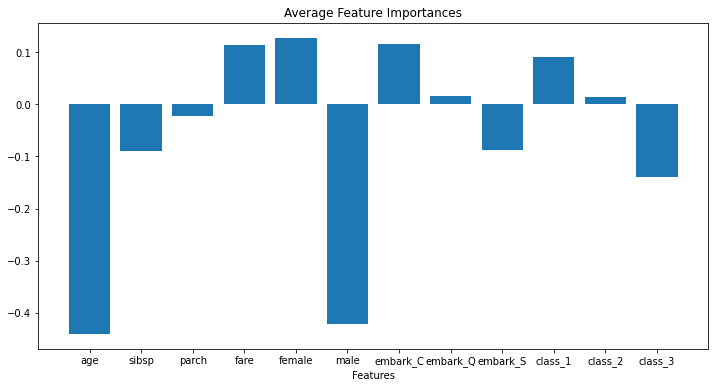

In [12]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

Feature Attribution 그래프에서 흥미로운 인사이트를 발견할 수 있었습니다.

나이와 남성인지 여부가 생존 여부에 큰 영향을 미쳤으며, 출발 장소와 자녀 여부는 적은 영향을 미쳤다는 것을 확인할 수 있었습니다.

또 흥미로운 점은 class3의 경우 생존 여부에 큰 영향을 미쳤음을 확인할 수 있었습니다.

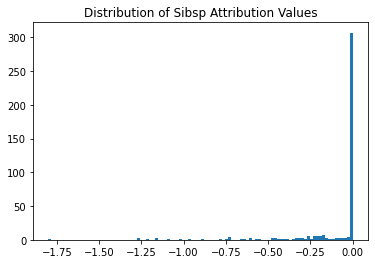

In [13]:
plt.hist(attr[:,1], 100);
plt.title("Distribution of Sibsp Attribution Values");

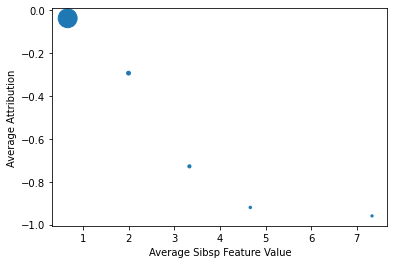

In [14]:
bin_means, bin_edges, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='mean', bins=6)
bin_count, _, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='count', bins=6)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.scatter(bin_centers, bin_means, s=bin_count)
plt.xlabel("Average Sibsp Feature Value");
plt.ylabel("Average Attribution");


### (2) Layer Attribution

다음으로 Captum Library에 내장되어 있는 다른 Feature Attribution 방법론인 **Layer Attributions** 을 사용하고자 합니다. 

Layer Attributiojn은 각각의 Neuron이 얼마나 영향을 미쳤는지 확인할 수 있는 방법입니다.


Layer attributions 관련 논문은 다음 링크에서 확인하세요! https://arxiv.org/abs/1805.12233.

Layer Conductance object를 생성한 후 어떤 Layer의 Output을 설명하고 싶은지 선택합니다.

이번 실습의 경우 첫번째 Hidden Layer의 Output인 net.sigmoid1 층을 선택하여 결과를 보겠습니다.

In [15]:
cond = LayerConductance(net, net.sigmoid1)

In [16]:
cond_vals = cond.attribute(test_input_tensor,target=1)
cond_vals = cond_vals.detach().numpy()

각각의 뉴런의 Average Conductance를 시각화합니다.

Average Neuron Importances
0 :  0.003
1 :  -0.168
2 :  0.024
3 :  0.010
4 :  -0.114
5 :  -0.044
6 :  0.009
7 :  0.000
8 :  -0.117
9 :  -0.000
10 :  -0.315
11 :  0.012


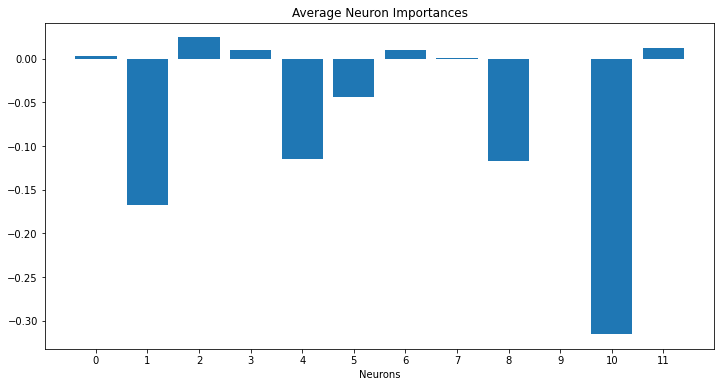

In [17]:
visualize_importances(range(12),np.mean(cond_vals, axis=0),title="Average Neuron Importances", axis_title="Neurons")

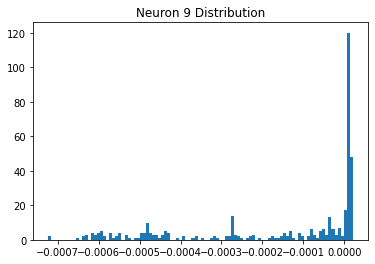

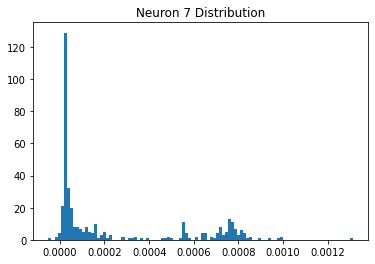

In [18]:
plt.hist(cond_vals[:,9], 100);
plt.title("Neuron 9 Distribution")
plt.figure()
plt.hist(cond_vals[:,7], 100);
plt.title("Neuron 7 Distribution");


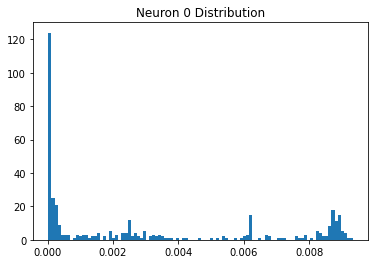

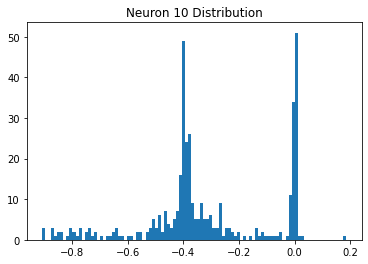

In [19]:
plt.hist(cond_vals[:,0], 100);
plt.title("Neuron 0 Distribution")
plt.figure()
plt.hist(cond_vals[:,10], 100);
plt.title("Neuron 10 Distribution");

위의 결과를 통해 어떤 뉴런은 중요한 Feature들을 학습하지 않는다는 것을 확인할 수 있습니다.

그렇다면 어떻게 이런 중요한 뉴런들이 무엇을 보고 있는지 알 수 있을까요? 중요 feature를 학습하는 뉴런과 그렇지 않은 뉴런의 차이는 무엇일까요?

이 질문에 답하기 위해 Captum Library의 다른 방법론인 **Neuron Attributions** 을 사용할 수 있습니다. 이는 어떤 input이 특정한 뉴런을 활성화시키는지 확인할 수 있게끔 만들어줍니다. 

### (3) Neuron Attributions

In [20]:
neuron_cond = NeuronConductance(net, net.sigmoid1)

In [21]:
neuron_cond_vals_10 = neuron_cond.attribute(test_input_tensor, neuron_selector=10, target=1)

In [22]:
neuron_cond_vals_0 = neuron_cond.attribute(test_input_tensor, neuron_selector=0, target=1)

Average Feature Importances for Neuron 0
age :  0.002
sibsp :  0.000
parch :  0.000
fare :  0.001
female :  0.000
male :  -0.000
embark_C :  0.000
embark_Q :  0.000
embark_S :  0.000
class_1 :  0.000
class_2 :  0.000
class_3 :  0.000


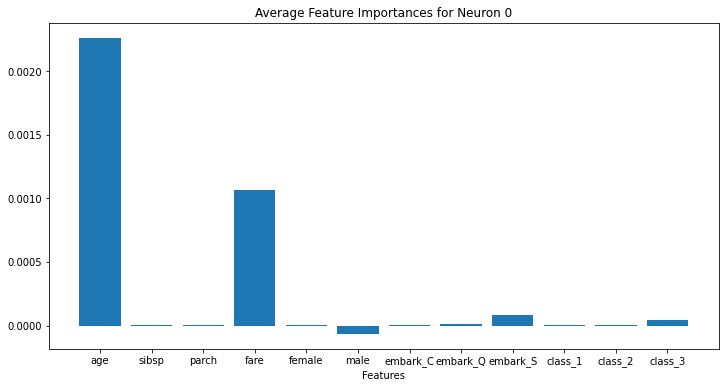

In [23]:
visualize_importances(feature_names, neuron_cond_vals_0.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 0")

위의 결과를 통해 뉴런 0은 age와 fare를 크게 고려하고 있음을 알 수 있습니다.

Average Feature Importances for Neuron 10
age :  -0.083
sibsp :  -0.012
parch :  0.006
fare :  0.007
female :  0.035
male :  -0.208
embark_C :  0.011
embark_Q :  -0.002
embark_S :  -0.045
class_1 :  0.035
class_2 :  0.022
class_3 :  -0.089


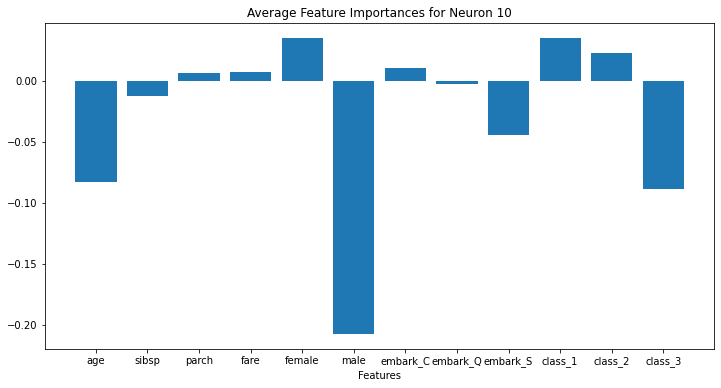

In [24]:
visualize_importances(feature_names, neuron_cond_vals_10.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 10")

위의 결과를 통해 뉴런 10은 gender를 가장 크게 고려하고 있으며, fare와 age를 비슷한 정도로 크게 고려하고 있다는 것을 확인할 수 있습니다.

## 인사이트

생존 예측과 같이 DNN을 기반으로 예측 모델을 만들 때 모델의 성능 만큼 중요한 것은 모델이 어떤 Feature를 중요하게 고려하고 있는지 여부를 알려주는 모델의 '해석가능성'과 '설명력'입니다.

Explainable AI(XAI)라는 이름으로 이 분야가 활발하게 연구되고 있으며, 다음 실습에서는 다양한 XAI 방법론을 담은 논문을 구현하거나, 실제 데이터에 적용해보는 실험을 진행해보고자 합니다.

감사합니다 :)

jhbale11